<a href="https://colab.research.google.com/github/iwanlevin/IndividualProjCosc310/blob/master/A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A8 (24 marks)
---
**Focus**: CUDA - Multi-dim kernel launches, Memory access, __device__ function calls.

This lab is a derivative of materials provided by PDC Center for High Performance Computing (HPC) and is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).

In this lab, we are going to be using Google Colab version and takes advantage of the free Cloud GPUs offered through the platform for CUDA development. Colab Notebooks (you're reading one right now!) are typically designed to run Python code, however, we'll be modifying them in such a way that we can run CUDA code (as discussed in the lectures) on the GPU.

Please note that your code will be written and run directly within this assignment. You will need to save a local copy and ensure that you save and upload your completed notebook to your GitHub repo for submission.

**CRITICAL**

Lastly, keep in mind that anytime your runtime disconnects or is restarted you must re-run the Notebook Setup code block. This applies to all CUDA assignments done using Google Colab.

**Details**

In this assignment, you will examine a use-case for using GPUs with images. The goal is to make you understand how to index 2D matrices, while doing something practical.

You are going to play with images and perform some basic image processing to create the base for an edge detector, such as
[Canny](https://en.wikipedia.org/wiki/Canny_edge_detector). The goal is to make
you understand how to index 2D matrices, while doing something fun and
practical. As a matter of fact, the results of the exercises below represent
some of the main image processing techniques used in Computer Vision that allow
for object and text recognition. If you would like to get a feeling on how the
final output would look, it will look like the following image

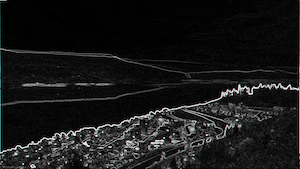


Once again, I'll encourage you to really understand the concepts explained within
the previous CUDA labs. If you do, then this block will be easy for you
to solve, as you will see.

##Setup and Background

We will use a different CUDA source code file to implement the exercises below which provides the framework for the lab as well as the serial implementation of the functions we want to parallelize on the GPU.

We also need a reference image file to process on each step. We will use the
file ``okanagan.bmp``, located inside the src folder.  This file will be copied to the Colab Notebook when you run the notebook setup code.  

This file is stored using the Bitmap (BMP) image format, a popular uncompressed format widely used by the Windows operating system. Each BMP file contains an encoded header that specifies the ``{width, height}`` of the image, the number of bits per color plane, and more. After the header, a subsequent string of interleaved color values follow (e.g., in BGR). Here is a simplified example of how a 3x3 image looks like inside the file:


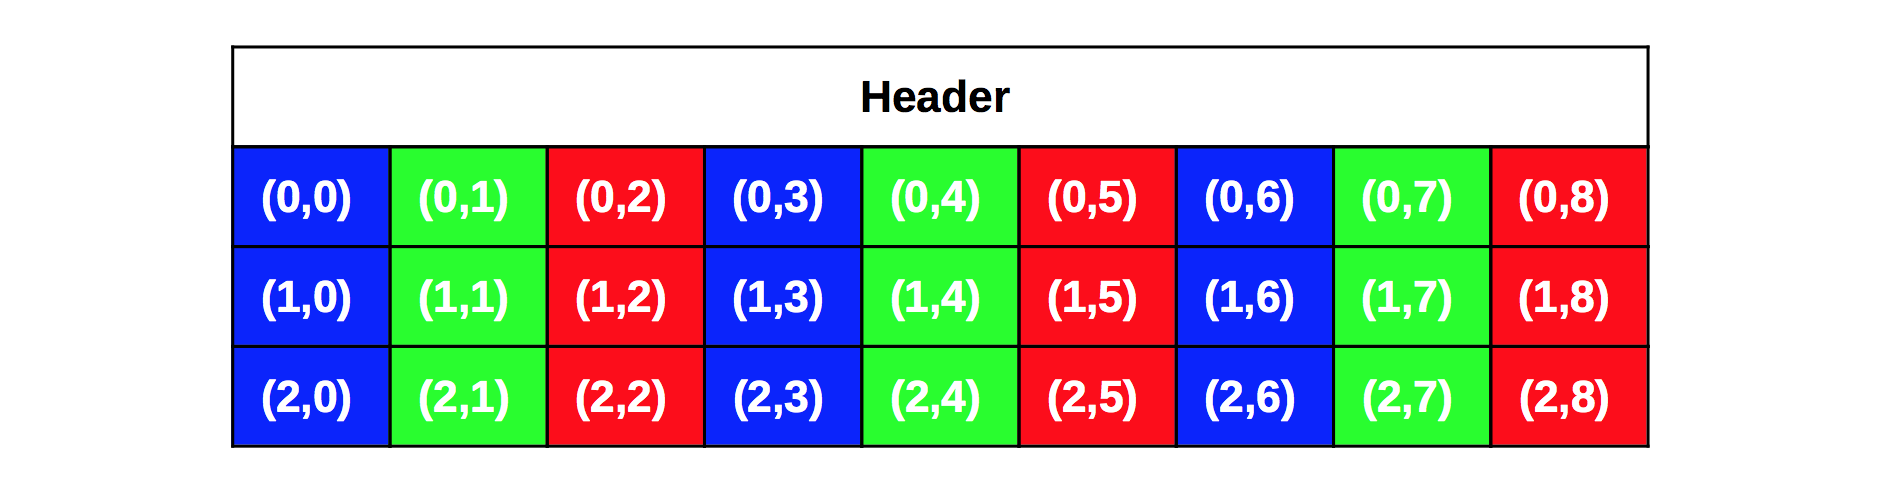

Each BGR, from Blue / Green / Red, represents an 8-bit pixel value in the image
that encodes the intensity of each channel. The values span from 0 to 255 in
the case of BMP 24bpp2, being 0 the absence of representation by this color and
255 the full representation.

> Other Bitmap formats, such as BMP 32bpp, can contain an extra Alpha channel
> for transparency.

This means that we could create a completely white image by setting all the
pixel values to 255, or the opposite, a completely black image setting them to 0.
One aspect of BMP files is that it is common to encounter that the pixel
values are stored bottom-up (i.e., as if the image pixels were flipped).

We provide you inside .cu file provided in the notebook, the functionality to read BMP 24bpp images and retrieve the pixel data in BGR format, as single-precision floating point values (suitable for the GPU).  The code is already setup to read the required file from the `src` folder.   We also provide other set of functionality, such
as a function to store BMP 8bpp files for Black & White images. **For this block
of exercises, you will _not_ need to handle any of these aspects. We will only
ask you to implement the kernels that perform the different image processing
steps that will be applied to the reference image.** Everything else, including
the set-up of CUDA in the ``main()`` function, is already defined inside
the file provided.

In this laboratory session, we will use the Python library PIL to render the images generated by each exercise.  The files from each part of the lab are named `result_1.bmp`, `result_2.bmp` and `result_3.bmp` and code have been proved at the end of the notebook to load the transformed images for reivew.

Before starting your solutions, but **AFTER** you setup your notebook, you can run a Python fragement that will load the original image (`okanagan.bmp`) to make sure that the image is in your notebook.

## Getting Started

1. Run the project setup cell (as you did in assignment A7). This pulls all the dependencies you will need for this project. Remember to rerun this cell anytime Google Colab allocates you a new instance.

2. Run the Pyhon fragment to ensure the the image is available for processing. 

3. Read the instructions and guidance below to complete the deliverables for the lab. 

## Marking Guide

--See README.md in repo

## What to Submit

For this assignment, you need to do the following:

1. Save your A8.ipynb file from Colab to GitHub.    Make sure that this file is saved (you have a copy) and it is successfully commited to your repo.   Ensure that your code solutions are in your Notebook as they will be marked from there. 

Note that you can resubmit an assignment, but the new submission overwrites the old submission and receives a new timestamp with GitHub.  Make sure to review the due date for this submission. 

## Notebook Setup

**Remember to re-run the following code block anytime you reconnect/connect/restart your Notebook!**

In [ ]:
# Download/Install/Enable NVCC4Jupyter
!pip install git+https://github.com/UBCO-COSC-407-Winter-2021-Term-1/nvcc4jupyter.git
%load_ext nvcc_plugin

# Download/UnZip Image
!pip install gdown
!gdown --id 1yDu2Yz23OaB1qdD8g46hEkKp-CfheaFK
#!curl  -o okanagan.zip "https://drive.google.com/file/d/1yDu2Yz23OaB1qdD8g46hEkKp-CfheaFK/view?usp=sharing"
!unzip okanagan.zip -d ./src 
!ls ./src/
!echo Finished!

## Image Test

**Run the following code fragment**
You should see the image of the Okanagan Valley that was used in the previous image processing lab (OpenMP).

In [ ]:
from PIL import Image
Image.open("./src/okanagan.bmp")

## Image Cleanup

In between runs of your code, you may wish to delete the result `bmp` files in the event you are troubleshooting and want a clean start (they will be over-written by updated versions).   Run the following code fragment to remove the results.

In [ ]:
#remove intermediate image files
!rm ./src/result_1.bmp
!rm ./src/result_2.bmp
!rm ./src/result_3.bmp
!ls ./src/

rm: cannot remove './src/result_1.bmp': No such file or directory
rm: cannot remove './src/result_2.bmp': No such file or directory
rm: cannot remove './src/result_3.bmp': No such file or directory
__MACOSX  okanagan.bmp


### Question #1 - Black and White Image Conversion

One of the frequent initial steps in the development of an edge detector is to
discard the color information and work directly in black & white. The idea is
to keep only the intensity of the pixels. For instance, if we consider a
[YUV](https://en.wikipedia.org/wiki/YUV) color space, which is very common in
video streams, one can easily work only on the Y plane and discard the color
information. The reason is that the Y plane (luminance) contains the intensity
of the pixel values, which represents the main content of the image. The UV
planes (chrominance) define the color or tint of the pixels, but they do not
necessarily add value to the features that we want to extract from the image.

The BMP image ``okanagan.bmp`` is encoded using a BGR color space, where the
combination of the individual intensities of each color value represent the
final intensity of the specific pixels. Therefore, the first step for our base
edge detector would be to combine these pixels in order to generate a BMP 8bpp
image in grayscale. In other words, we want only 8 bits per pixel.

For the conversion to grayscale, we are going to use the
[Colorimetric](https://en.wikipedia.org/wiki/Grayscale) (luminance-preserving)
method. This conversion guarantees that both the original and converted image
maintains the same absolute luminance. In practice terms, what we are going to
do is to take each BGR value of the Bitmap file and apply the following
conversion using the weighted sum of the three values:

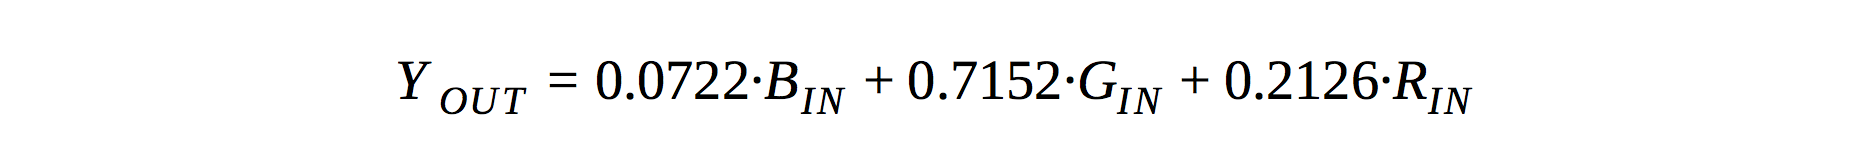

___
**TO-DO [1.1]**

Briefly examine the overall content of the file in the notebook below. Pay particular attention to the
``cpu_greyscale()`` function and try to understand how the color conversion is
done on the CPU given a BGR 24bpp image plane.
___

As you might have noticed in the ``cpu_greyscale()`` implementation, the color
conversion is relatively simple. The input image is represented as an encoded
2D image in a 1D array, where each row is consecutively stored in memory. We
retrieve the input pixel by considering each one as a BGR value (i.e.,
3&times;``float``).  In fact, the rows are separated by the ``width`` of the image
multiplied by the number of colors per pixel. On the other hand, we store the
output Y value considering that the image plane now contains only one color
value per pixel.  Once again, the output is a 2D array encoded as a 1D array.
In this case, each row is only separated from the ``width`` of the image plane.  You can actually just run the code as-is and it will generate the images using the serial implementation (handy for testing 😀).

From now on, we will use the converted image in grayscale as the input for the
subsequent operations. We now ask you to implement the same ``cpu_greyscale()``
function, but using a GPU kernel in CUDA instead.

---
**TO-DO [2.2] (10 marks)**

Find the declaration of ``gpu_greyscale()`` in the code and implement the GPU
version of the black & white color conversion filter. The source code is
already set-up to call the kernel and generate the output, but you will need to
uncomment the code inside ``main()``.   If you do not correctly uncomment the kernel launch and CUDA memory operations, the code will use the serial implementation.

+ Hint #1: The kernel is launched with a 2D ``grid`` of 2D ``blocks``. Consider
  calculating the ID of the thread in the Y direction to select the specific
  row, and the ID of the thread in the X direction to select the specific
  column.
+ Hint #2: The boundaries of the image cannot be exceeded. You must include an
  ``if``-statement to prevent any issues, based on the ``width`` and ``height``
  parameters.

---

After you have implemented the kernel, you should be able to see the result of
the color conversion. Compile the code with ``nvcc`` (push the play button beside the code block as in previous labs).  The code will run and store a new image called `result_1.bmp` inside the `src`
folder.  Visualize the result with the python code found at the bottom of the notebook.  It will display the converted image in black & white, such as this:



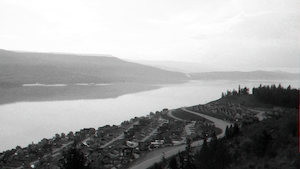

### Question #2 - Applying a Convolution Filter

Converting the input image to black & white was a very good first step towards
implementing our edge detector. For this exercise, we are going to apply a
Gaussian filter to smooth the grayscale image that was generated through the
kernel.

In Image Processing, a Gaussian _blur_ is the result of blurring an image by the
means of a Gaussian function. The visual effect is equivalent to looking at the
image through a translucent screen, as if the image suddenly became a thin
layer of colored candy. Depending on the intensity of the filter, the Gaussian
blur can provide multiple benefits. For instance, it can be used to reduce the
image noise. The reason is that the filter effectively reduces the
high-frequency components of a given image.

We need this filter as an intermediate step towards increasing the quality of
the result of exercise #3, where we will apply a Sobel filter to define the
edges of the image (i.e., the Sobel filter is very sensitive to noise). **For
this exercise, we are going to apply a Gaussian filter using a 3&times;3
convolution matrix on all the pixels of the image.** The term convolution is the
result of adding each pixel to its local neighbours, weighted by the matrix
values:

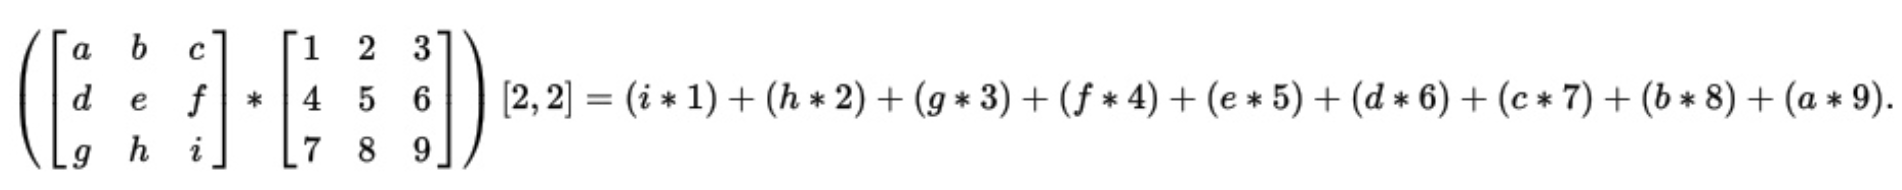

The * operator represents the convolution, not a matrix multiplication.
Here, what you have to consider is to map each pixel as the center of the 3&times;3
convolution matrix and apply the weights with the surrounding pixels. As we use
symmetric filters, the order can be top-bottom as well.

---
**TO-DO [2.1]**

Find the implementation of ``cpu_applyFilter()`` inside the code and
try to understand how a given convolution matrix is applied to a certain pixel.

+ Hint #1: The input block of the image is given by the top-left corner, not
  the center of the block (the target pixel).
+ Hint #2: This is not a matrix-matrix multiplication, keep this in mind while
  reviewing the source code.

---

We already provide you with an implementation of ``cpu_gaussian()`` and
``gpu_gaussian()``, that contains the CPU and GPU implementation, respectively.
Both versions already define a 3×3 convolution filter that constitutes the
result of applying a Gaussian function to a particular pixel. Therefore, **we ask
you to implement a device function ``gpu_applyFilter()`` that allows any CUDA
kernel to apply a convolution filter given by parameter**. Remember that, in
CUDA, device functions can be declared with the ``__device__`` modifier. The syntax
is very similar to a plain C function, with the difference that now the GPU can
see this code as well and the GPU kernel will be able to call this function directly.

---
**TO-DO [2.2] (2 marks)**

Implement the ``gpu_applyFilter()`` in the code that allows to apply any kind
of convolution matrix to a certain pixel. Will the GPU code differ from the CPU
code in this case? Examine the implementation of ``gpu_gaussian()`` to understand
the execution flow.

+ Hint #1: The ``gpu_applyFilter()`` is called with a single thread from
  ``gpu_gaussian()``. **Do not parallelize it!** (Each thread needs to call this).
+ Hint #2: In some situations, the CPU code and the GPU code can be shared
  [https://goo.gl/Wz8iyG](https://goo.gl/Wz8iyG).

---

With the functionality for applying the convolution filter on the GPU ready, we
can now generate the second output result. Make sure you uncomment the
execution of the kernel inside `main()`, otherwise you will not see the GPU
version enabled.

Compile the code with `nvcc` (push the play button beside the code block as in previous labs).  The code will run and store a new image called `result_2.bmp` inside the `src`
folder.  Visualize the result with the python code found at the bottom of the notebook.  It will display the converted image in black & white, such as this:


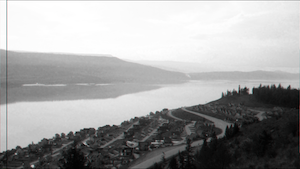

The image blow shows a cropped section of original black & white image (left), and a cropped section of the blurred image (right). The differences are very subtle, but you should be able to notice some differences:

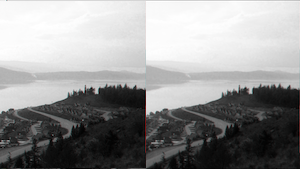

If you did not manage to get any differences, please, make sure that you have correctly enabled the new version of the xxx_applyFilter() inside the gpu_gaussian() kernel. Ask for help to the TAs if you cannot make any progress.

### Question #3 - Detecting Edges in the Image

The very last step of our base edge detector is to apply the Sobel filter. With
this filter, we are going to compute an approximation of the gradient of the
image intensity function. This allows us to create a new image where the edges
are emphasized, which constitutes the base for full edge detection algorithms
such as [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector).

The filter uses two 3×3 kernels which are convolved with the original image
to calculate approximations of the derivatives on the horizontal and vertical
directions. In other words, if we define **A** as the source image, and **G**_x_ and **G**_y_
as two convolution matrices that generate the horizontal and vertical
derivative approximations, the computations are as follow:

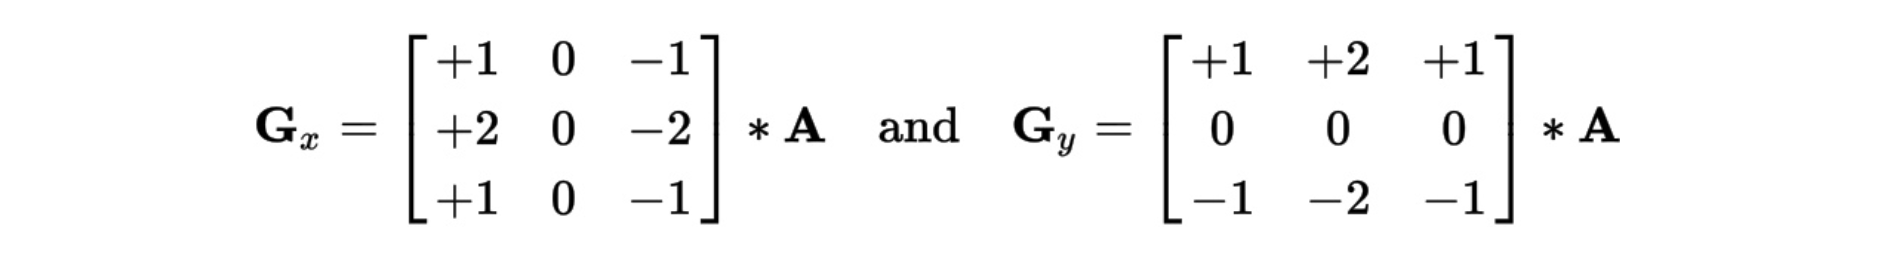

The resultant gradient magnitude of the pixel is obtained by calculating the
square root of these:

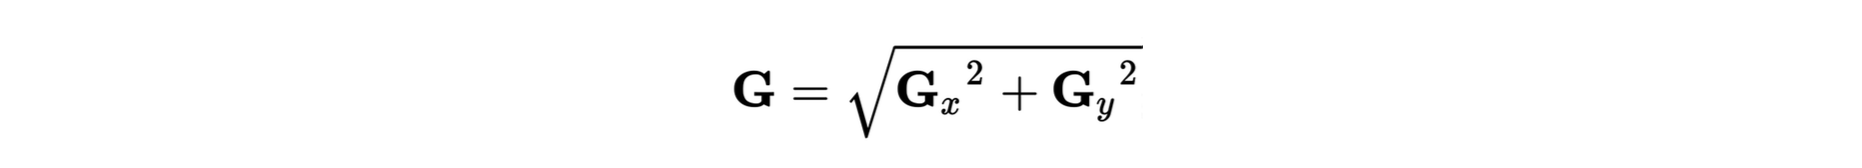

For the last exercise, we want you to implement the GPU version of ``cpu_sobel()``,
which is already declared in the code  under the name ``gpu_sobel()``. The
implementation of this function is very similar to ``gpu_gaussian()``, except for
the fact that the we apply two different convolution filters to the same pixel
and combine the result.

---
**TO-DO [3.1] (10 marks)**

Implement `gpu_sobel()` in the code to enable the execution of the Sobel
filter on the GPU. Pay special attention to the indices used on the CPU
implementation ``cpu_sobel()`` to avoid any issues with the final result.

+ Hint #1: You can use the ``sqrtf()`` function to calculate the square root, as in
  the CPU code.
+ Hint #2: It might be interesting for you to examine first how ``gpu_gaussian()``
  has been implemented.

With the implementation of ``gpu_sobel()`` in place, we are almost done with the
laboratory session of today. Make sure you uncomment the execution of the
kernel inside ``main()``, otherwise you will not see the GPU version enabled.

Compile the code with nvcc (push the play button beside the code block as in previous labs). The code will run and store a new image called result_3.bmp inside the src folder. Visualize the result with the python code found at the bottom of the notebook. It will display the converted image in black & white, such as this:

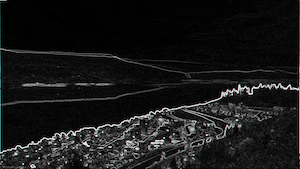

## The Code
(Embed your solutions in this file).

In [ ]:
%%cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/time.h>
#include <cuda_runtime.h>
#include "device_launch_parameters.h"

#define BLOCK_SIZE  16
#define HEADER_SIZE 122

typedef unsigned char BYTE;

/**
 * Structure that represents a BMP image.
 */
typedef struct
{
    int   width;
    int   height;
    float *data;
} BMPImage;

typedef struct timeval tval;

BYTE g_info[HEADER_SIZE]; // Reference header

/**
 * Reads a BMP 24bpp file and returns a BMPImage structure.
 * Thanks to https://stackoverflow.com/a/9296467
 */
BMPImage readBMP(char *filename)
{
    BMPImage bitmap = { 0 };
    int      size   = 0;
    BYTE     *data  = NULL;
    FILE     *file  = fopen(filename, "rb");
    
    // Read the header (expected BGR - 24bpp)
    fread(g_info, sizeof(BYTE), HEADER_SIZE, file);

    // Get the image width / height from the header
    bitmap.width  = *((int *)&g_info[18]);
    bitmap.height = *((int *)&g_info[22]);
    size          = *((int *)&g_info[34]);
    
    // Read the image data
    data = (BYTE *)malloc(sizeof(BYTE) * size);
    fread(data, sizeof(BYTE), size, file);
    
    // Convert the pixel values to float
    bitmap.data = (float *)malloc(sizeof(float) * size);
    
    for (int i = 0; i < size; i++)
    {
        bitmap.data[i] = (float)data[i];
    }
    
    fclose(file);
    free(data);
    
    return bitmap;
}

/**
 * Writes a BMP file in grayscale given its image data and a filename.
 */
void writeBMPGrayscale(int width, int height, float *image, char *filename)
{
    FILE *file = NULL;
    
    file = fopen(filename, "wb");
    
    // Write the reference header
    fwrite(g_info, sizeof(BYTE), HEADER_SIZE, file);
    
    // Unwrap the 8-bit grayscale into a 24bpp (for simplicity)
    for (int h = 0; h < height; h++)
    {
        int offset = h * width;
        
        for (int w = 0; w < width; w++)
        {
            BYTE pixel = (BYTE)((image[offset + w] > 255.0f) ? 255.0f :
                                (image[offset + w] < 0.0f)   ? 0.0f   :
                                                               image[offset + w]);
            
            // Repeat the same pixel value for BGR
            fputc(pixel, file);
            fputc(pixel, file);
            fputc(pixel, file);
        }
    }
    
    fclose(file);
}

/**
 * Releases a given BMPImage.
 */
void freeBMP(BMPImage bitmap)
{
    free(bitmap.data);
}

/**
 * Checks if there has been any CUDA error. The method will automatically print
 * some information and exit the program when an error is found.
 */
void checkCUDAError()
{
    cudaError_t cudaError = cudaGetLastError();
    
    if(cudaError != cudaSuccess)
    {
        printf("CUDA Error: Returned %d: %s\n", cudaError,
                                                cudaGetErrorString(cudaError));
        exit(-1);
    }
}

/**
 * Calculates the elapsed time between two time intervals (in milliseconds).
 */
double get_elapsed(tval t0, tval t1)
{
    return (double)(t1.tv_sec - t0.tv_sec) * 1000.0L + (double)(t1.tv_usec - t0.tv_usec) / 1000.0L;
}

/**
 * Stores the result image and prints a message.
 */
void store_result(int index, double elapsed_cpu, double elapsed_gpu,
                     int width, int height, float *image)
{
    char path[255];
    
    sprintf(path, "./src/result_%d.bmp", index);
    writeBMPGrayscale(width, height, image, path);
    
    printf("Step #%d Completed - Result stored in \"%s\".\n", index, path);
    printf("Elapsed CPU: %fms / ", elapsed_cpu);
    
    if (elapsed_gpu == 0)
    {
        printf("[GPU version not available]\n");
    }
    else
    {
        printf("Elapsed GPU: %fms\n", elapsed_gpu);
    }
}


////////////////
// TO-DO #1.1 /////////////////////////////////////////////
// Examine this code //
///////////////////////////////////////////////////////////
/**
 * Converts a given 24bpp image into 8bpp grayscale using the CPU.
 */
void cpu_grayscale(int width, int height, float *image, float *image_out)
{
    for (int h = 0; h < height; h++)
    {
        int offset_out = h * width;      // 1 color per pixel
        int offset     = offset_out * 3; // 3 colors per pixel
        
        for (int w = 0; w < width; w++)
        {
            float *pixel = &image[offset + w * 3];
            
            // Convert to grayscale following the "luminance" model
            image_out[offset_out + w] = pixel[0] * 0.0722f + // B
                                        pixel[1] * 0.7152f + // G
                                        pixel[2] * 0.2126f;  // R
        }
    }
}

/**
 * Converts a given 24bpp image into 8bpp grayscale using the GPU.
 */
__global__ void gpu_grayscale(int width, int height, float *image, float *image_out)
{
    ////////////////
    // TO-DO #1.2 /////////////////////////////////////////////
    // Implement the GPU version of the grayscale conversion //
    // Remember that this is now a 2D  problem (what does x  //
    // map to and what does y map to)                        //
    ///////////////////////////////////////////////////////////
   
}

////////////////
// TO-DO #2.1 ////////////////////////////////////////////////
// Examine how the colvoluation filter is applied to a given//
// pixel.                                                   //
// Does it make sense to have a separate gpu_applyFilter()? //
//////////////////////////////////////////////////////////////
/**
 * Applies a 3x3 convolution matrix to a pixel using the CPU.
 */
float cpu_applyFilter(float *image, int stride, float *matrix, int filter_dim)
{
    float pixel = 0.0f;
    
    for (int h = 0; h < filter_dim; h++)
    {
        int offset        = h * stride;
        int offset_kernel = h * filter_dim;
        
        for (int w = 0; w < filter_dim; w++)
        {
            pixel += image[offset + w] * matrix[offset_kernel + w];
        }
    }
    
    return pixel;
}

/**
 * Applies a 3x3 convolution matrix to a pixel using the GPU.
 */
__device__ float gpu_applyFilter(float *image, int stride, float *matrix, int filter_dim)
{
    ////////////////
    // TO-DO #2.2 ////////////////////////////////////////////////
    // Implement the GPU version of cpu_applyFilter()           //
    //                                                          //
    // Does it make sense to have a separate gpu_applyFilter()? //
    //////////////////////////////////////////////////////////////
    
    return 0.0f;
}

/**
 * Applies a Gaussian 3x3 filter to a given image using the CPU.
 */
void cpu_gaussian(int width, int height, float *image, float *image_out)
{
    float gaussian[9] = { 1.0f / 16.0f, 2.0f / 16.0f, 1.0f / 16.0f,
                          2.0f / 16.0f, 4.0f / 16.0f, 2.0f / 16.0f,
                         1.0f / 16.0f, 2.0f / 16.0f, 1.0f / 16.0f };

    for (int h = 0; h < (height - 2); h++)
    {
        int offset_t = h * width;
        int offset   = (h + 1) * width;
        
        for (int w = 0; w < (width - 2); w++)
        {
            image_out[offset + (w + 1)] = cpu_applyFilter(&image[offset_t + w],
                                                          width, gaussian, 3);                                                  
        }
    }
}

/**
 * Applies a Gaussian 3x3 filter to a given image using the GPU.
 */
__global__ void gpu_gaussian(int width, int height, float *image, float *image_out)
{
    float gaussian[9] = { 1.0f / 16.0f, 2.0f / 16.0f, 1.0f / 16.0f,
                          2.0f / 16.0f, 4.0f / 16.0f, 2.0f / 16.0f,
                          1.0f / 16.0f, 2.0f / 16.0f, 1.0f / 16.0f };
    
    int index_x = blockIdx.x * blockDim.x + threadIdx.x;
    int index_y = blockIdx.y * blockDim.y + threadIdx.y;
    
    if (index_x < (width - 2) && index_y < (height - 2))
    {
        int offset_t = index_y * width + index_x;
        int offset   = (index_y + 1) * width + (index_x + 1);
        
        image_out[offset] = gpu_applyFilter(&image[offset_t],
                                            width, gaussian, 3);
    }
}

/**
 * Calculates the gradient of an image using a Sobel filter on the CPU.
 */
void cpu_sobel(int width, int height, float *image, float *image_out)
{
    float sobel_x[9] = { 1.0f,  0.0f, -1.0f,
                         2.0f,  0.0f, -2.0f,
                         1.0f,  0.0f, -1.0f };
    float sobel_y[9] = { 1.0f,  2.0f,  1.0f,
                         0.0f,  0.0f,  0.0f,
                        -1.0f, -2.0f, -1.0f };
    
    for (int h = 0; h < (height - 2); h++)
    {
        int offset_t = h * width;
        int offset   = (h + 1) * width;
        
        for (int w = 0; w < (width - 2); w++)
        {
            float gx = cpu_applyFilter(&image[offset_t + w], width, sobel_x, 3);
            float gy = cpu_applyFilter(&image[offset_t + w], width, sobel_y, 3);
            
            // Note: The output can be negative or exceed the max. color value
            // of 255. We compensate this afterwards while storing the file.
            image_out[offset + (w + 1)] = sqrtf(gx * gx + gy * gy);
        }
    }
}

/**
 * Calculates the gradient of an image using a Sobel filter on the GPU.
 */
__global__ void gpu_sobel(int width, int height, float *image, float *image_out)
{
    ////////////////
    // TO-DO #3.1 /////////////////////////////////////
    // Implement the GPU version of the Sobel filter //
    ///////////////////////////////////////////////////
 
}

// This code attempts to check if a GPU has been allocated
// Colab notebooks technically have access to NVCC and will compile and
// execute CPU/Host code, however, GPU/Device code will silently fail.
// To prevent such situations, this code will warn the user.
void checkForGPU() 
{
    
    int count;
    cudaGetDeviceCount(&count);
    if (count <= 0 || count > 100) {
        printf("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n");
        printf("->WARNING<-: NO GPU DETECTED ON THIS COLLABORATE INSTANCE.\n");
        printf("IF YOU ARE ATTEMPTING TO RUN GPU-BASED CUDA CODE, YOU SHOULD CHANGE THE RUNTIME TYPE!\n");
        printf("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n");
    }
}

int main(int argc, char **argv)
{
    BMPImage bitmap          = { 0 };
    float    *d_bitmap       = { 0 };
    float    *image_out[2]   = { 0 };
    float    *d_image_out[2] = { 0 };
    int      image_size      = 0;
    tval     t[2]            = { 0 };
    double   elapsed[2]      = { 0 };
    dim3     grid(1);                       // The grid will be defined later
    dim3     block(BLOCK_SIZE, BLOCK_SIZE); // The block size will not change

    printf("starting the code...\n");
    checkForGPU(); 
 
    // Read the input image and update the grid dimension
    bitmap     = readBMP("./src/okanagan.bmp");
 
    image_size = bitmap.width * bitmap.height;
    grid       = dim3(((bitmap.width  + (BLOCK_SIZE - 1)) / BLOCK_SIZE),
                      ((bitmap.height + (BLOCK_SIZE - 1)) / BLOCK_SIZE));
    
    printf("Image opened (width=%d height=%d).\n", bitmap.width, bitmap.height);
    
    // Allocate the intermediate image buffers for each step
    for (int i = 0; i < 2; i++)
    {
        image_out[i] = (float *)calloc(image_size, sizeof(float));
        
        cudaMalloc(&d_image_out[i], image_size * sizeof(float));
        cudaMemset(d_image_out[i], 0, image_size * sizeof(float));
    }
    
    // Moving image to card
    cudaMalloc(&d_bitmap, image_size * sizeof(float) * 3);
    cudaMemcpy(d_bitmap, bitmap.data,
               image_size * sizeof(float) * 3, cudaMemcpyHostToDevice);
    
    // Step 1: Convert to grayscale
    {
        // Launch the CPU version (use this to check that things work on CPU)
        gettimeofday(&t[0], NULL);
        
        cpu_grayscale(bitmap.width, bitmap.height, bitmap.data, image_out[0]);
        gettimeofday(&t[1], NULL);
        
        elapsed[0] = get_elapsed(t[0], t[1]);
        
        // Launch the GPU version
        // uncomment the following lines to run GPU code 
        gettimeofday(&t[0], NULL);
        
        //gpu_grayscale<<<grid, block>>>(bitmap.width, bitmap.height, 
        //                                          d_bitmap, d_image_out[0]);
        //checkCUDAError();
        //cudaMemcpy(image_out[0], d_image_out[0],
        //            image_size * sizeof(float), cudaMemcpyDeviceToHost);

        gettimeofday(&t[1], NULL);
        
        elapsed[1] = get_elapsed(t[0], t[1]);
        
        // Store the result image in grayscale
        store_result(1, elapsed[0], elapsed[1], bitmap.width, bitmap.height, image_out[0]);
    }
  
    
    // Step 2: Apply a 3x3 Gaussian filter
    {
        // Launch the CPU version
        gettimeofday(&t[0], NULL);
        
        cpu_gaussian(bitmap.width, bitmap.height, image_out[0], image_out[1]);
        gettimeofday(&t[1], NULL);
        
        elapsed[0] = get_elapsed(t[0], t[1]);
             
        // Launch the GPU version
        // uncomment the following lines to run GPU code 
        gettimeofday(&t[0], NULL);
     
        //gpu_gaussian<<<grid, block>>>(bitmap.width, bitmap.height,
        //                               d_image_out[0], d_image_out[1]);
        //checkCUDAError();
        //cudaMemcpy(image_out[1], d_image_out[1],
        //            image_size * sizeof(float), cudaMemcpyDeviceToHost);
        
        gettimeofday(&t[1], NULL);
        
        elapsed[1] = get_elapsed(t[0], t[1]);
        
        // Store the result image with the Gaussian filter applied
        store_result(2, elapsed[0], elapsed[1], bitmap.width, bitmap.height, image_out[1]);
    }
    
    // Step 3: Apply a Sobel filter
    {
        // Launch the CPU version
        gettimeofday(&t[0], NULL);
     
        cpu_sobel(bitmap.width, bitmap.height, image_out[1], image_out[0]);
        gettimeofday(&t[1], NULL);
        
        elapsed[0] = get_elapsed(t[0], t[1]);
         
        // Launch the GPU version
        // uncomment the following lines to run GPU code 
        gettimeofday(&t[0], NULL);
        
        //gpu_sobel<<<grid, block>>>(bitmap.width, bitmap.height,
        //                            d_image_out[1], d_image_out[0]);
        //checkCUDAError();
        //cudaMemcpy(image_out[0], d_image_out[0],
        //            image_size * sizeof(float), cudaMemcpyDeviceToHost);
        
        gettimeofday(&t[1], NULL);
        
        elapsed[1] = get_elapsed(t[0], t[1]);
        
        // Store the final result image with the Sobel filter applied
        store_result(3, elapsed[0], elapsed[1], bitmap.width, bitmap.height, image_out[0]);
    }
    
    // Release the allocated memory
    for (int i = 0; i < 2; i++)
    {
        free(image_out[i]);
        cudaFree(d_image_out[i]);
    }
    
    freeBMP(bitmap);
    cudaFree(d_bitmap);
    
    return 0;
}


### Question #4 - Timing Results (2 marks)
 
Using the timing fraemwork provided, time your code and report the speedup of using your CUDA implementation vs. the provided serial implementation in the space provided in the notebook.  Clearing report the serial time,  parallel time and the speedup.

In [ ]:
#Comment on Timing results here

## Show Images

To display the created test.bmp image, run the code block below

**BW Image Result**

In [ ]:
from PIL import Image
Image.open("./src/result_1.bmp")

**Blur Result**

In [ ]:
from PIL import Image
Image.open("./src/result_2.bmp")

**Edge Detecion Result**

In [ ]:
from PIL import Image
Image.open("./src/result_3.bmp")

## Submission Instructions

For this assignment, you need to do the following:

1. Save your A8.ipynb file from Colab to GitHub.    Make sure that this file is saved (you have a copy) and it is successfully commited to your repo.   Ensure that your code solutions are in your Notebook as they will be marked from there. 

Note that you can resubmit an assignment, but the new submission overwrites the old submission and receives a new timestamp with GitHub.  Make sure to review the due date for this submission. 